In [1]:
import einops

from functools import partial
from itertools import product
import numpy as np
from pathlib import Path
from plotnine import (
    ggplot,
    geom_point, 
    geom_histogram, 
    geom_line,
    geom_ribbon,
    qplot, 
    coord_fixed, 
    aes, 
    facet_wrap, 
    labs,
    scale_x_log10,
    scale_y_log10
)
import polars as pl
import torch

from tokengrams import MemmapIndex, InMemoryIndex
from tqdm.notebook import tqdm
from transformers import AutoTokenizer
from transformer_lens import HookedTransformerConfig

from ngram_markov.hooked_transformer import HookedTransformer
from torch.nn.functional import softmax, log_softmax


import collections
from collections import defaultdict
from itertools import islice
import numpy as np
import rustworkx as rx


from ngram_markov.model import GPT, GPTConfig
from ngram_markov.utils import create_ngrams, nanogpt_to_hooked_transformer_config, convert_nanogpt_weights
import einops
import torch
import plotly.express as px



In [2]:
from ngram_markov.ngrams import create_ngrams, calculate_ngram_kl_divergence, kl_divergence
import collections
from itertools import islice


def load_nnsight_model(path):
    ckpt = torch.load(path, map_location='cpu')
    config = nanogpt_to_hooked_transformer_config(ckpt['model_args'])
    tl_weights = convert_nanogpt_weights(ckpt['model'], config)
    tl_model = HookedTransformer(config)
    tl_model.load_state_dict(tl_weights)
    return  LanguageModel(tl_model)


def load_tl_model(path):
    ckpt = torch.load(path, map_location='cpu')
    config = nanogpt_to_hooked_transformer_config(ckpt['model_args'])
    tl_weights = convert_nanogpt_weights(ckpt['model'], config)
    tl_model = HookedTransformer(config)
    tl_model.load_state_dict(tl_weights)
    return tl_model


def estimate_unigram_kl(model, unigram_counts, num_batches, num_layers, vocab_size):
    layer_kl = {i: [] for i in range(num_layers + 1)}
    for i in range(num_batches):
        batch, _ = get_batch('train')
        #ngrams = create_ngrams(batch.cpu(), n-1)
        #counts = torch.tensor(index.batch_count_next(ngrams.reshape(-1, n-1).numpy(), 511), dtype=torch.float32)
        ngram_dist = torch.asarray((unigram_counts / unigram_counts.sum()))
        log_ngrams = torch.log(ngram_dist + 1.0e-10).to('cuda')
        for layer, logits in get_layerwise_logits(model, batch, num_layers).items():
            logprobs = torch.log_softmax(logits[:, (n-2):, :], dim=-1)
            layer_kl[layer].append(kl_divergence(log_ngrams, logprobs))
    return {layer : torch.stack(kls, dim=0).squeeze().detach().cpu() for layer, kls in layer_kl.items()}


@torch.no_grad()
def estimate_ngram_kl(model, index, n, num_batches, vocab_size):
    local_full_kl_divs = []
    ngram_local_kl_divs = []
    ngram_full_kl_divs = []
    batch_size, seq_len = get_batch().shape
    mask = create_local_attention_mask(seq_len, n, batch_size).to('cuda')
    for i in range(num_batches):
        batch = get_batch()
        ngrams = create_ngrams(batch.cpu(), n-1)
        counts = torch.tensor(index.batch_count_next(ngrams.reshape(-1, n-1).numpy()), dtype=torch.float32)
        ngram_dist = (counts / counts.sum(dim=1, keepdims=True)).reshape(batch.shape[0], batch.shape[1] - n + 2, vocab_size)
        log_ngrams = torch.log(ngram_dist + 1.0e-10).to('cuda')
        full_logits = torch.log_softmax(model(batch)[:, (n - 2):, :], dim=-1) 
        local_logits = torch.log_softmax(model(batch, additive_attention_mask=mask)[:, (n-2):, :], dim=-1)

        l2f_kl = kl_divergence(local_logits, full_logits)
        n2l_kl = kl_divergence(log_ngrams, local_logits)
        n2f_kl = kl_divergence(log_ngrams, full_logits)
        local_full_kl_divs.append(l2f_kl)
        ngram_local_kl_divs.append(n2l_kl)
        ngram_full_kl_divs.append(n2f_kl)

    l2f = torch.stack(local_full_kl_divs, dim=0).squeeze().detach().cpu()
    n2l = torch.stack(ngram_local_kl_divs, dim=0).squeeze().detach().cpu()
    n2f = torch.stack(ngram_full_kl_divs, dim=0).squeeze().detach().cpu()
    df = pl.DataFrame({
        "local_to_full": l2f.ravel().cpu().numpy(),
        "ngram_to_local": n2l.ravel().cpu().numpy(), 
        "ngram_to_full": n2f.ravel().cpu().numpy()
    })
    return df
    


def get_kl_for_model(ckpt_path, iteration, ngram_vals, num_batches):
    unigram_dist = np.load('data/tinystories/ngrams/1grams.npy')
    ckpt = torch.load(ckpt_path / f'ckpt{iteration}.pt')
    num_layers = ckpt['model_args']['n_layer']
    vocab_size = ckpt['model_args']['vocab_size']
    config = nanogpt_to_hooked_transformer_config(ckpt['model_args'])
    tl_weights = convert_nanogpt_weights(ckpt['model'], config)
    model = HookedTransformer(config)
    model.load_state_dict(tl_weights)
    model.eval()
    ngram_dfs = {}
    for n in ngram_vals:
        if n == 1:
            ckpt_kl = estimate_unigram_kl(model, unigram_dist, num_batches, num_layers, vocab_size)
        else:
            ckpt_kl = estimate_layer_kl(model, n, num_batches, num_layers, vocab_size)
        data = {str(layer) : kl.ravel().numpy() for layer, kl in ckpt_kl.items()} 
        #for layer, v in data.items():
        #    print(f'{layer}: {v.shape}')
        ngram_dfs[n] = pl.DataFrame(data).melt(variable_name='layers').with_columns(steps=pl.lit(iteration))
    return ngram_dfs
    
    

def create_local_attention_mask(seq_len: int, window_size: int, batch_size: int = 1, device='cpu') -> torch.Tensor:
    """
    Creates a mask for local attention where each token can only attend to
    the previous window_size tokens and itself, while maintaining causality.
    
    Args:
    seq_len (int): The sequence length.
    window_size (int): The number of previous tokens to attend to.
    batch_size (int): The batch size.
    
    Returns:
    torch.Tensor: A boolean mask of shape (batch_size, 1, seq_len, seq_len).
    """
    # Create a causal mask
    causal_mask = torch.tril(torch.ones(seq_len, seq_len))
    
    # Create a local attention mask
    local_mask = torch.triu(torch.ones(seq_len, seq_len), diagonal=1-window_size)
    
    # Combine causal and local masks
    mask = causal_mask * local_mask
    
    # Add batch and head dimensions
    mask = mask.unsqueeze(0).unsqueeze(0).expand(batch_size, 1, seq_len, seq_len)
    mask = torch.logical_not(mask).float().masked_fill(mask == 0, float('-inf'))
    
    return mask.to(device)


def get_batch(batch_size=32, block_size=1024):
    # We recreate np.memmap every batch to avoid a memory leak, as per
    # https://stackoverflow.com/questions/45132940/numpy-memmap-memory-usage-want-to-iterate-once/61472122#61472122
    data = np.memmap(data_dir / 'train.bin', dtype=np.uint16, mode='r')
    ix = torch.randint(len(data) - block_size, (batch_size,))
    x = torch.stack([torch.from_numpy((data[i:i+block_size]).astype(np.int64)) for i in ix])
    if device_type == 'cuda':
        # pin arrays x,y, which allows us to move them to GPU asynchronously (non_blocking=True)
        x
    else:
        x = x.to(device)
    return x


def sliding_window(iterable, n):
    "Collect data into overlapping fixed-length chunks or blocks."
    # sliding_window('ABCDEFG', 4) → ABCD BCDE CDEF DEFG
    iterator = iter(iterable)
    window = collections.deque(islice(iterator, n - 1), maxlen=n)
    for x in iterator:
        window.append(x)
        yield tuple(window)


# Example usage:
# seq_len = 1024
# window_size = 256
# batch_size = 1
# local_mask = create_local_attention_mask(seq_len, window_size, batch_size)


import rustworkx as rx
import numpy as np
from typing import List, Tuple
from collections import defaultdict
from itertools import islice

weight_eps = 0.0001

class NgramNode:

    def __init__(self, ngram: Tuple[int]):
        self.ngram = ngram

    def __repr__(self):
        return self.ngram.__repr__()

    @property
    def n(self):
        return len(self.ngram) + 1



def seq_to_debruijn(rw, n):
    return [ngram for ngram in sliding_window(rw, n-1)]




def get_largest_sc_subgraph(graph):
    largest_scc = []
    scc_len = -1
    for cc in rx.strongly_connected_components(graph):
        if len(cc) > scc_len:
            largest_scc = cc
            scc_len = len(cc)
    return graph.subgraph(largest_scc, preserve_attrs=True)




In [28]:
import torch
import rustworkx as rx
import numpy as np
from typing import List, Tuple
from collections import defaultdict
from itertools import islice


class NgramNode:
    def __init__(self, ngram: Tuple[int], probability: float):
        self.ngram = ngram
        self.probability = probability

    def __repr__(self):
        return f"{self.ngram} (p={self.probability:.4f})"



def get_local_probabilities(model, input_ids, window_size):
    seq_len = input_ids.shape[1]
    batch_size = input_ids.shape[0]
    local_mask = create_local_attention_mask(seq_len, window_size, batch_size, device=input_ids.device)
    
    with torch.no_grad():
        logits = model(input_ids, additive_attention_mask=local_mask)
        #logits = outputs.logits
        probs = torch.softmax(logits, dim=-1)
    
    return probs


def create_weighted_debruijn_subgraph(model, random_walks: List[List[int]], n: int, window_size: int, device) -> rx.PyDiGraph:
    # Step 1: Get local probabilities
    input_ids = torch.tensor(random_walks, device=device)
    probs = get_local_probabilities(model, input_ids, window_size)
    
    # Step 2: Create a set of unique n-grams (nodes)
    ngram_walks = [seq_to_debruijn(rw, n) for rw in random_walks]
    unique_ngrams = set()
    for walk in ngram_walks:
        unique_ngrams.update(walk)
    unique_ngrams = list(unique_ngrams)
    
    # Step 3: Create a dictionary to map n-grams to node indices
    ngram_to_index = {ngram: i for i, ngram in enumerate(unique_ngrams)}
    
    # Step 4: Create nodes with probabilities
    nodes = []
    for ngram in unique_ngrams:
        batch_idx, seq_idx = np.where(np.all(np.array(random_walks)[:, :-n+1] == ngram, axis=1))[0]
        prob = probs[batch_idx, seq_idx + n - 1, ngram[-1]].item()
        nodes.append(NgramNode(ngram, prob))
    
    # Step 5: Create edges
    edges = []
    for ngram in unique_ngrams:
        source = ngram_to_index[ngram]
        for next_token in range(probs.shape[-1]):
            next_ngram = ngram[1:] + (next_token,)
            if next_ngram in ngram_to_index:
                target = ngram_to_index[next_ngram]
                edges.append((source, target))
    
    # Step 6: Build the rustworkx graph
    graph = rx.PyDiGraph()
    graph.add_nodes_from(nodes)
    graph.add_edges_from(edges)
    
    return graph, ngram_to_index


def graph_to_tensor(graph):
    num_nodes = graph.num_nodes()
    adj_matrix = torch.zeros(num_nodes, num_nodes)
    node_weights = torch.zeros(num_nodes)
    
    for i, node in enumerate(graph.nodes()):
        node_weights[i] = node.probability
        for neighbor in graph.neighbors(i):
            adj_matrix[i, neighbor] = 1
    
    return adj_matrix, node_weights

def analyze_model_with_debruijn(model, random_walks, n, window_size):
    graph, ngram_to_index = create_weighted_debruijn_subgraph(model, random_walks, n, window_size)
    adj_matrix, node_weights = graph_to_tensor(graph)
    
    # Perform eigendecomposition
    eigenvalues, eigenvectors = torch.linalg.eig(adj_matrix)
    
    # Sort eigenvalues and eigenvectors
    sorted_indices = torch.argsort(eigenvalues.abs(), descending=True)
    sorted_eigenvalues = eigenvalues[sorted_indices]
    sorted_eigenvectors = eigenvectors[:, sorted_indices]
    
    return graph, adj_matrix, node_weights, sorted_eigenvalues, sorted_eigenvectors

# Example usage
rw_n = 3  # N-gram size for the de Bruijn graph
window_size = 3  # Local attention window size

batch = get_batch(256, 256)

graph, ngram_to_index = create_weighted_debruijn_subgraph(model, batch.cpu().tolist(), rw_n, window_size, 'cuda')
adj_matrix, node_weights = graph_to_tensor(graph)

#result = analyze_model_with_debruijn(model, random_walks, rw_n, window_size)

ValueError: operands could not be broadcast together with shapes (256,254) (2,) 

In [3]:
epoch = 53_000
model_path = Path('/media/External01/ngram-checkpoints/4layer_tinystories')
data_dir = Path('data/tinystories')

batch_size = 32
block_size = 256
device_type = 'cpu'
device = 'cpu'

In [4]:
model = load_tl_model(model_path / f'ckpt{epoch}.pt')
model.eval()

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-3): 4 x TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resi

In [5]:
trigrams = torch.cartesian_prod(torch.arange(512), torch.arange(512), torch.arange(512))

In [11]:
trigrams.split(2**17)[-1].shape

torch.Size([131072, 3])

In [6]:
batch_size = 2 ** 17

with torch.no_grad():
    outs = model(trigrams[:batch_size].to('cuda:0'))
    

OutOfMemoryError: CUDA out of memory. Tried to allocate 6.00 GiB. GPU 

In [9]:
(512 ** 4)/ (2 ** 17)

524288.0

In [17]:
from pathlib import Path

ts_bin_path = 'data/tinystories/train.bin'
index_path = "data/tinystories/ngrams/suffix_tree.idx"

#index = MemmapIndex(ts_bin_path, index_path, 512)

In [18]:
@torch.no_grad()
def estimate_local_kl(model, window_sizes, num_batches):
    local_full_kl_divs = {n: [] for n in window_sizes}
    
    
    for i in range(num_batches):
        batch = get_batch()
        batch_size, seq_len = batch.shape
        full_logits = torch.log_softmax(model(batch), dim=-1) 
        

        for window in window_sizes:
            mask = create_local_attention_mask(seq_len, window, batch_size).to('cuda')
            local_logits = torch.log_softmax(model(batch, additive_attention_mask=mask)[:, window:, :], dim=-1)
            local_full_kl_divs[window].append(
                kl_divergence(local_logits, full_logits[:, window:, :])
            )
    dfs = []
    for n, divs in local_full_kl_divs.items():
        df = pl.DataFrame({'kl_div': torch.stack(divs, dim=0).squeeze().ravel().cpu().numpy()}).with_columns(n=pl.lit(n))
        dfs.append(df)
    return pl.concat(dfs, how='vertical')


In [ ]:
df = estimate_local_kl(model, [1, 2, 4, 8, 16, 32, 64, 128, 256, 512], 500)
df.head()

In [ ]:
df.group_by('n').agg(mean_div = pl.col('kl_div').mean(), min_div=pl.col('kl_div').min(), max_div=pl.col('kl_div').max())

In [71]:
#plot = ggplot(df, aes(x='kl_div', fill='factor(n)')) + geom_histogram(binwidth=1) + facet_wrap('~n')

In [7]:
from plotnine import theme

#plot + labs(x = 'Local Attention vs. Full Model KL', y = 'Count', fill = 'Window Size') + theme(figure_size=(14, 14))

In [8]:
checkpoint_steps = [int(fp.name.lstrip('ckpt').rstrip('.pt')) for fp in model_path.iterdir() if fp.name.endswith('pt')]
parquet_dir = Path('local_v_full')

def compare_local_models(path, ckpt_step, window_sizes, num_batches):
    model = load_tl_model(path)
    model.eval()
    df = estimate_local_kl(model, window_sizes, num_batches)
    return df.with_columns(num_steps=pl.lit(ckpt_step))


sizes = [1, 2, 4, 8, 16, 32, 64, 128, 256, 512]

#for steps in tqdm(checkpoint_steps):
#    data = compare_local_models(model_path / f'ckpt{steps}.pt', steps, sizes, 250)
#    data.write_parquet(parquet_dir / f'{steps}.parquet')
    

In [9]:
all_data =  pl.scan_parquet(parquet_dir.iterdir())

In [11]:

steps_data = []


for step in tqdm(checkpoint_steps):
    df = (
        all_data
        .filter(pl.col('num_steps').eq(step))
        .group_by(['num_steps', 'n'])
        .agg(
            mean_kl = pl.col('kl_div').mean(),
            med_kl = pl.col('kl_div').median(),
            q25_kl = pl.col('kl_div').quantile(0.25),
            q75_kl = pl.col('kl_div').quantile(0.75),
            q90_kl = pl.col('kl_div').quantile(0.90),
        )
        .collect()
    )
    steps_data.append(df)


  0%|          | 0/77 [00:00<?, ?it/s]

In [13]:
data = pl.concat(steps_data, how='vertical')


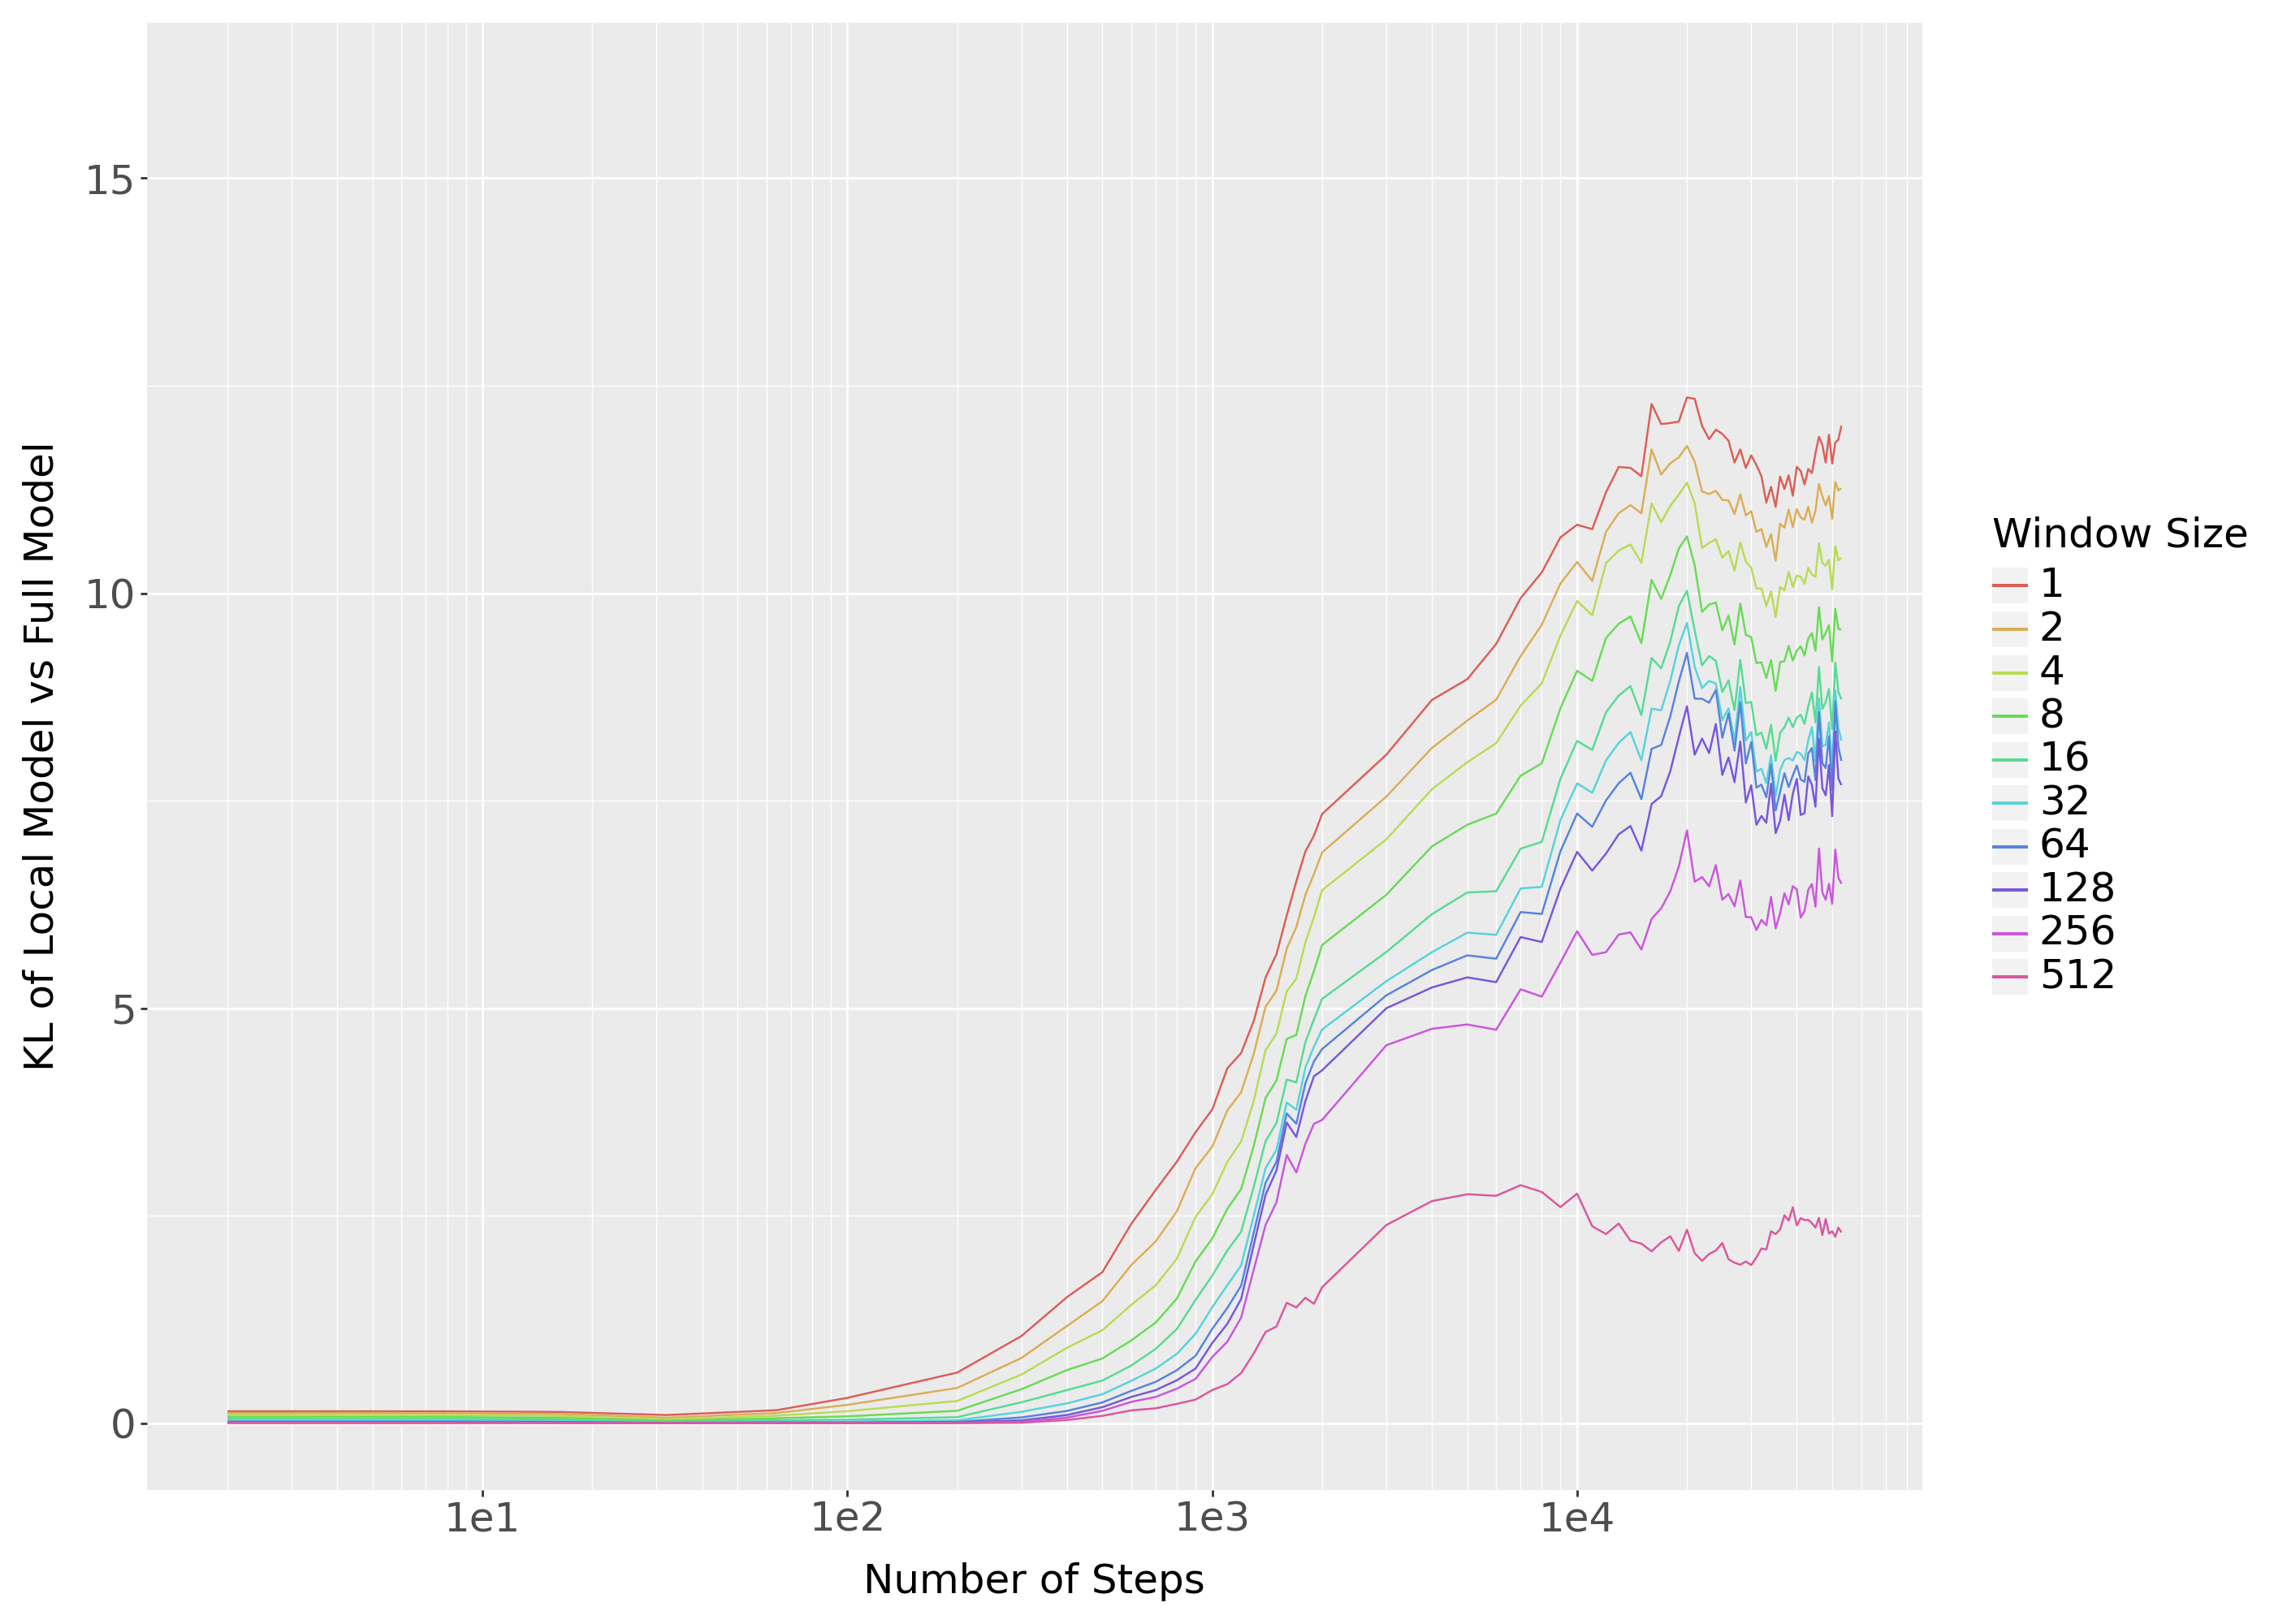

In [24]:
from plotnine import element_text

(
    ggplot(
        data, 
        aes(x='num_steps', y='med_kl', ymin='q25_kl', ymax='q75_kl', color='factor(n)')
    ) + 
    geom_line() + 
    scale_x_log10() + 
    labs(x = 'Number of Steps', y = 'KL of Local Model vs Full Model', color='Window Size') + 
    theme(figure_size=(14, 10), text=element_text(size=18))
)
    

In [25]:
import torch

def total_variation_distance(p: torch.Tensor, q: torch.Tensor) -> torch.Tensor:
    """
    Calculate the total variation distance between two discrete probability distributions.
    This function supports batch operations.
    
    Args:
    p (torch.Tensor): First probability distribution(s)
    q (torch.Tensor): Second probability distribution(s)
    
    Returns:
    torch.Tensor: Total variation distance(s)
    
    Note: Input tensors should be of shape (batch_size, num_events) or (num_events,)
          and each distribution should sum to 1 along the last dimension.
    """
    # Ensure inputs have the same shape
    assert p.shape == q.shape, "Input tensors must have the same shape"
    
    # Add batch dimension if inputs are 1D
    if p.dim() == 1:
        p = p.unsqueeze(0)
        q = q.unsqueeze(0)
    
    # Ensure inputs are 2D tensors now
    assert p.dim() == 2, "Input tensors must be 2-dimensional (batch_size, num_events)"
    
    # Ensure inputs sum to 1 along the last dimension (within a small tolerance)
    assert torch.all(torch.isclose(p.sum(dim=-1), torch.tensor(1.0), atol=1e-6)), "First input tensor must sum to 1 along last dimension"
    assert torch.all(torch.isclose(q.sum(dim=-1), torch.tensor(1.0), atol=1e-6)), "Second input tensor must sum to 1 along last dimension"
    
    # Calculate the total variation distance
    return torch.max(torch.abs(p - q), dim=-1)[0]




In [35]:
@torch.no_grad()
def estimate_ngram_kl(model, index, n, num_batches, vocab_size):
    local_full_dist = []
    ngram_local_dist = []
    ngram_full_dist = []
    batch_size, seq_len = get_batch().shape
    mask = create_local_attention_mask(seq_len, n - 1, batch_size).to('cuda')
    for i in range(num_batches):
        batch = get_batch()
        ngrams = create_ngrams(batch.cpu(), n-1)
        counts = torch.tensor(index.batch_count_next(ngrams.reshape(-1, n-1).numpy()), dtype=torch.float32)
        ngram_dist = (counts / counts.sum(dim=1, keepdims=True))
        ngram_dist = ngram_dist.to('cuda').reshape(batch.shape[0], batch.shape[1] - n + 2, vocab_size)
        full_logits = torch.softmax(model(batch)[:, (n - 2):, :], dim=-1).reshape(-1, vocab_size)
        local_logits = torch.softmax(model(batch, additive_attention_mask=mask)[:, (n-2):, :], dim=-1).reshape(-1, vocab_size)

        l2f_tv = total_variation_distance(local_logits, full_logits)
        n2l_tv = total_variation_distance(ngram_dist.reshape(-1, vocab_size), local_logits)
        n2f_tv = total_variation_distance(ngram_dist.reshape(-1, vocab_size), full_logits)
        local_full_dist.append(l2f_tv)
        ngram_local_dist.append(n2l_tv)
        ngram_full_dist.append(n2f_tv)

    l2f = torch.stack(local_full_dist, dim=0).squeeze().detach().cpu()
    n2l = torch.stack(ngram_local_dist, dim=0).squeeze().detach().cpu()
    n2f = torch.stack(ngram_full_dist, dim=0).squeeze().detach().cpu()
    df = pl.DataFrame({
        "local_vs_full": l2f.ravel().cpu().numpy(),
        "ngram_vs_local": n2l.ravel().cpu().numpy(), 
        "ngram_vs_full": n2f.ravel().cpu().numpy()
    })
    return df
    



In [39]:
epoch = 53_000
model = load_tl_model(model_path / f'ckpt{epoch}.pt')
model.eval()

HookedTransformer(
  (embed): Embed()
  (hook_embed): HookPoint()
  (pos_embed): PosEmbed()
  (hook_pos_embed): HookPoint()
  (blocks): ModuleList(
    (0-3): 4 x TransformerBlock(
      (ln1): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (ln2): LayerNorm(
        (hook_scale): HookPoint()
        (hook_normalized): HookPoint()
      )
      (attn): Attention(
        (hook_k): HookPoint()
        (hook_q): HookPoint()
        (hook_v): HookPoint()
        (hook_z): HookPoint()
        (hook_attn_scores): HookPoint()
        (hook_pattern): HookPoint()
        (hook_result): HookPoint()
      )
      (mlp): MLP(
        (hook_pre): HookPoint()
        (hook_post): HookPoint()
      )
      (hook_attn_in): HookPoint()
      (hook_q_input): HookPoint()
      (hook_k_input): HookPoint()
      (hook_v_input): HookPoint()
      (hook_mlp_in): HookPoint()
      (hook_attn_out): HookPoint()
      (hook_mlp_out): HookPoint()
      (hook_resi

In [48]:
df = estimate_ngram_kl(model, index, 4, 50, 512)

In [50]:
df.mean()

local_vs_full,ngram_vs_local,ngram_vs_full
f32,f32,f32
0.756804,0.547164,0.367679


In [51]:
df

local_vs_full,ngram_vs_local,ngram_vs_full
f32,f32,f32
0.0,0.08542,0.08542
0.367874,0.418162,0.058224
0.412009,0.41208,0.101666
0.09595,0.088983,0.048744
0.836193,0.220318,0.821819
…,…,…
0.631897,0.424402,0.625194
0.882654,0.226796,0.850103
0.51518,0.174321,0.490584


In [ ]:
parquet_dir = Path('local_v_ngram')

def compare_local_models(path, ckpt_step, index, n, num_batches, vocab_size):
    model = load_tl_model(path)
    model.eval()
    df = estimate_ngram_kl(model, index, n, num_batches, vocab_size)
    return df.with_columns(num_steps=pl.lit(ckpt_step), n=pl.lit(n)).melt(id_vars=['n', 'num_steps'])


n_values = [2, 3, 4, 5]

for steps in tqdm(checkpoint_steps):
    ckpt_data = []
    for n in n_values:
        data = compare_local_models(model_path / f'ckpt{steps}.pt', steps, index, n, 100, 512)
        ckpt_data.append(data)
    pl.concat(ckpt_data).write_parquet(parquet_dir / f'{steps}.parquet')
 

  0%|          | 0/77 [00:00<?, ?it/s]

In [56]:
data.head()

n,num_steps,variable,value
i32,i32,str,f32
5,9000,"""local_vs_full""",0.0
5,9000,"""local_vs_full""",0.123273
5,9000,"""local_vs_full""",0.645822
5,9000,"""local_vs_full""",0.314217
5,9000,"""local_vs_full""",0.102329


In [ ]:
all_data =  pl.scan_parquet(parquet_dir.iterdir())

steps_data = []


for step in tqdm(checkpoint_steps):
    df = (
        all_data
        .filter(pl.col('num_steps').eq(step))
        .group_by(['num_steps', 'n', 'variable'])
        .agg(
            mean_kl = pl.col('value').mean(),
            med_kl = pl.col('value').median(),
            q25_kl = pl.col('value').quantile(0.25),
            q75_kl = pl.col('value').quantile(0.75),
            q90_kl = pl.col('value').quantile(0.90),
        )
        .collect()
    )
    steps_data.append(df)



In [59]:
data = pl.concat(steps_data)

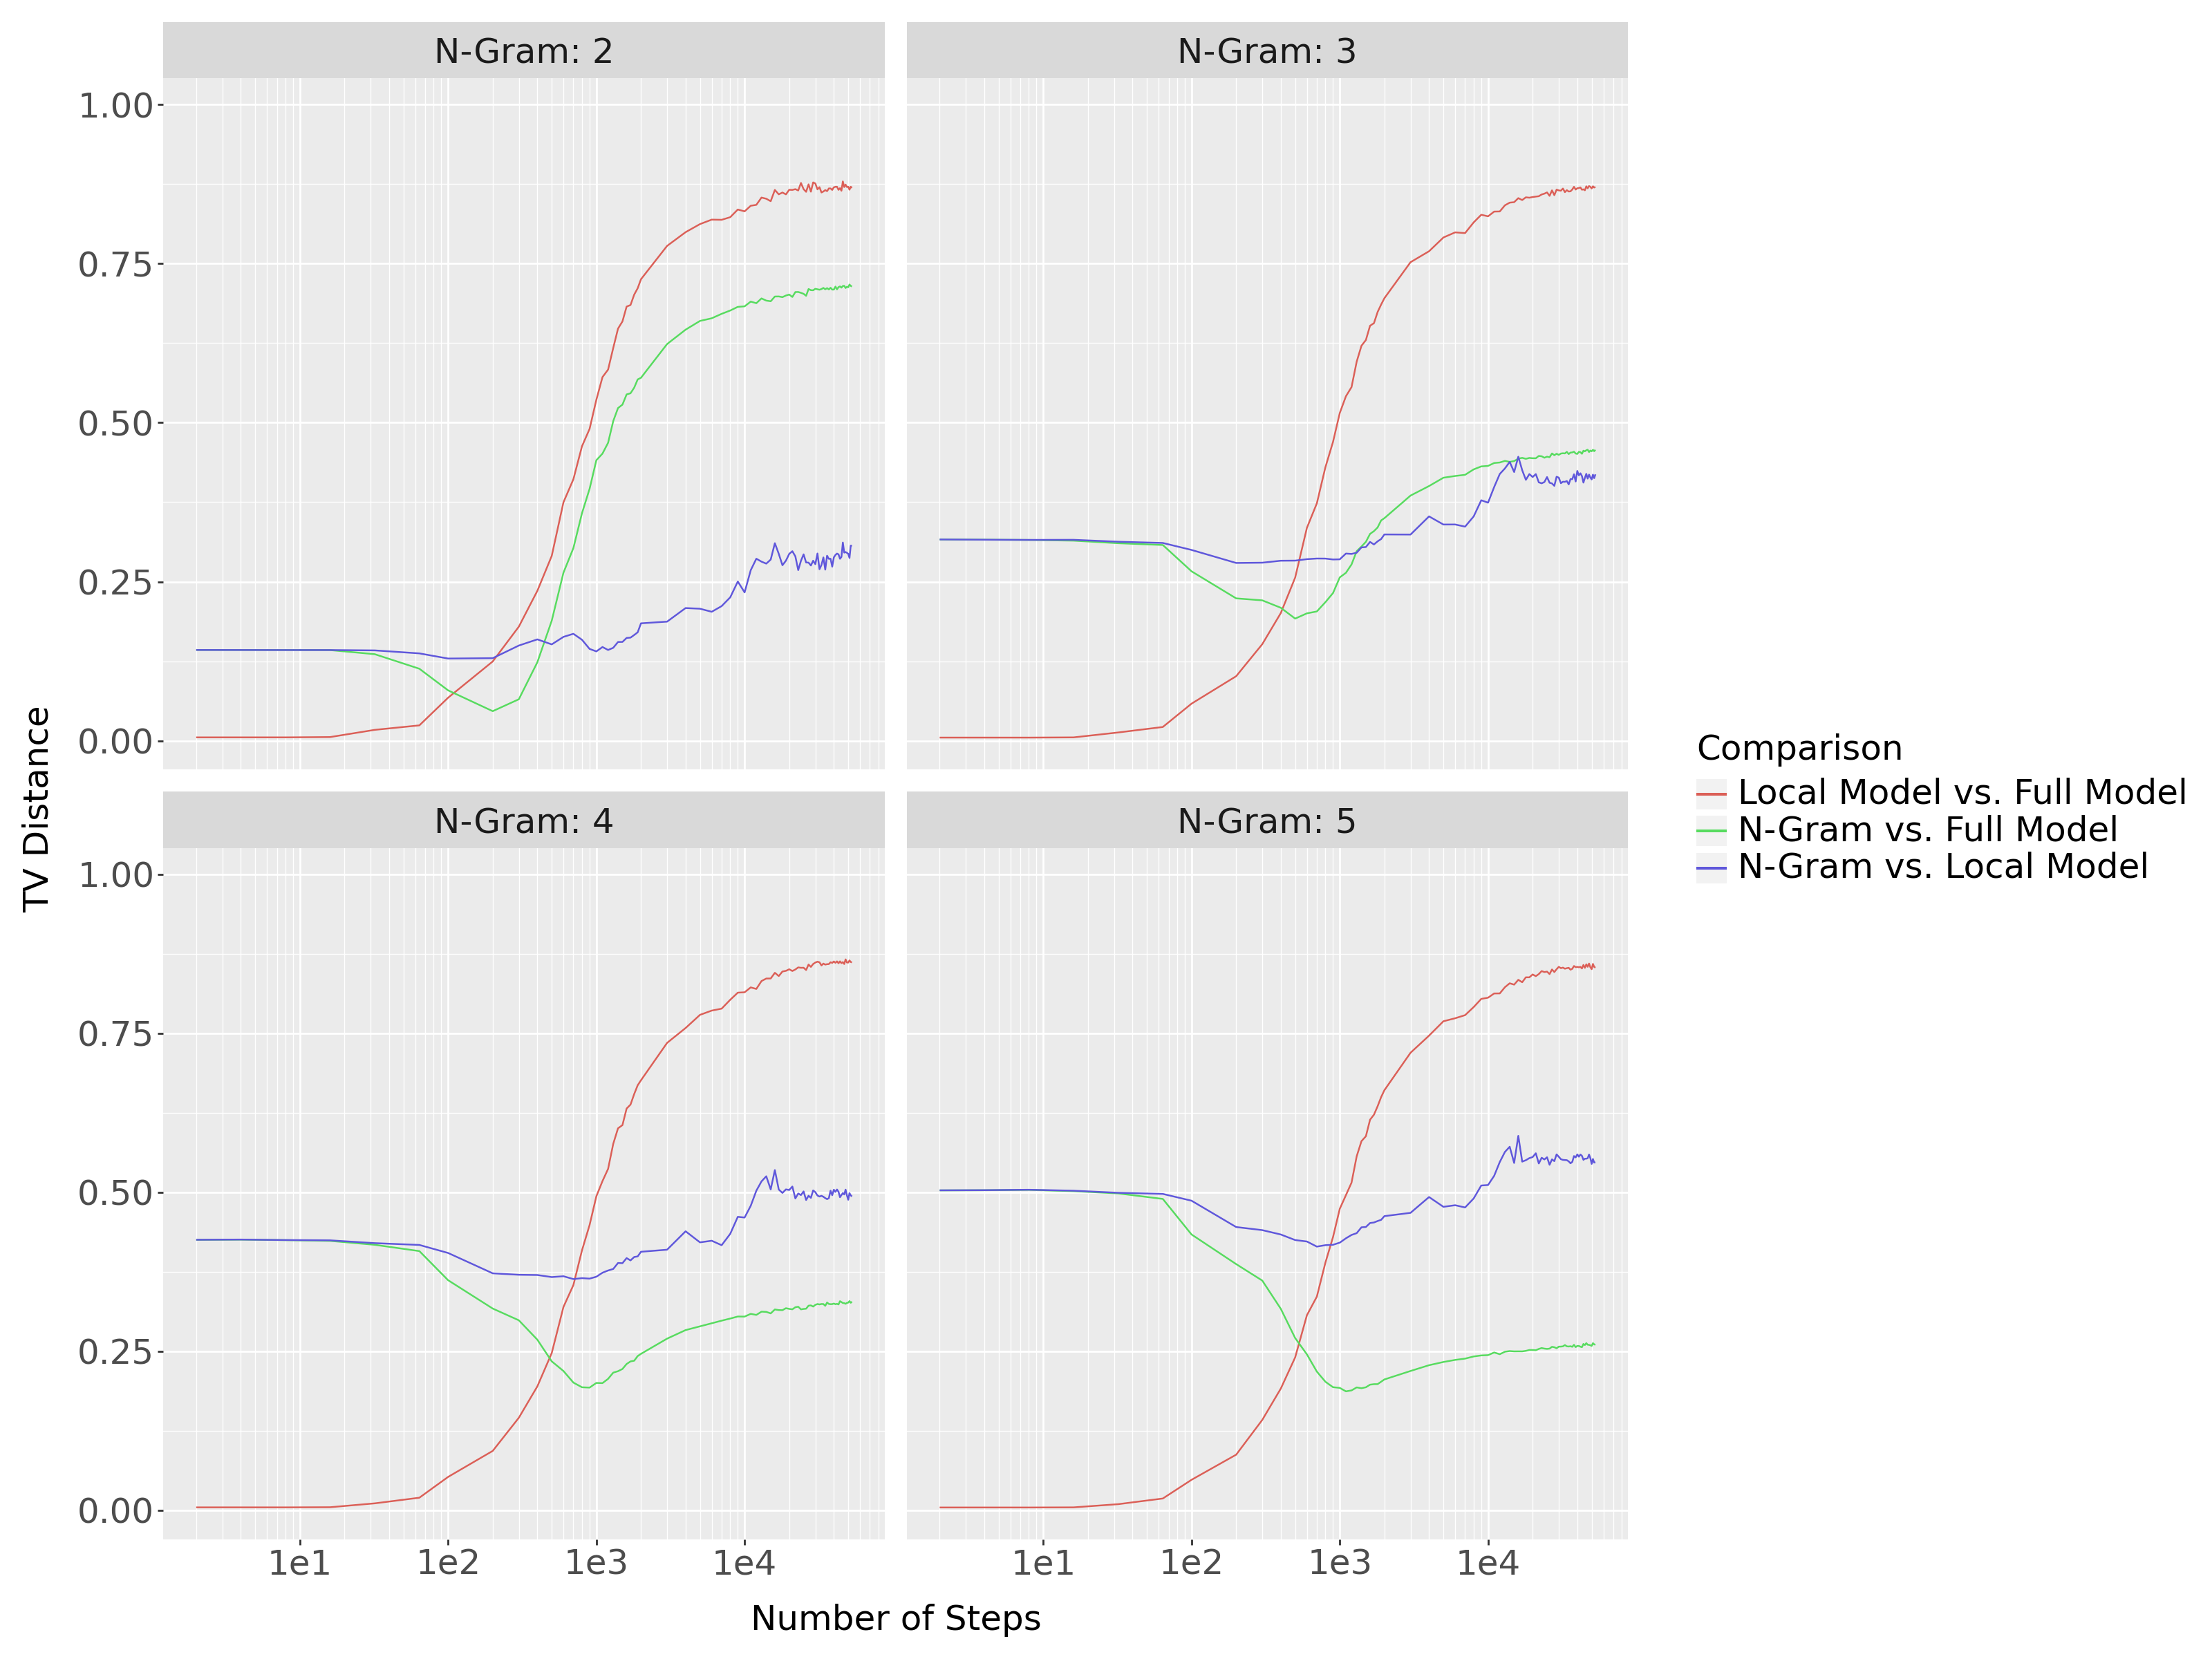

In [73]:
ngram_vals = {2: 'N-Gram: 2', 3: 'N-Gram: 3', 4: 'N-Gram: 4', 5: 'N-Gram: 5'}
variable_vals =  {
    'local_vs_full': 'Local Model vs. Full Model',
    'ngram_vs_full': 'N-Gram vs. Full Model',
    'ngram_vs_local': 'N-Gram vs. Local Model'
}

df = data.with_columns(pl.col('variable').replace(variable_vals), pl.col('n').replace(ngram_vals))

(
    ggplot(df, aes(x='num_steps', y='med_kl', ymin='q25_kl', ymax='q75_kl', color='variable', fill='variable')) 
    + geom_line() 
    + facet_wrap('~n')
    + scale_x_log10()
    + theme(figure_size=(16, 12), text=element_text(size=18))
    + labs(x = 'Number of Steps', y = 'TV Distance', color='Comparison')
)